## Observations and Insights 

In [63]:
# Define column constants
class Columns:
    mouse_id = "Mouse ID"
    drug_regimen = "Drug Regimen"
    sex = "Sex"
    age = "Age_months"
    weight = "Weight (g)"
    timepoint = "Timepoint"
    tumor_volume = "Tumor Volume (mm3)"
    metastatic_sites = "Metastatic Sites"

# Define other constants
pct_fmt = "%1.1f%%"

In [167]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import random

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_study_df = pd.merge(mouse_metadata, study_results, on=Columns.mouse_id)

# Display the data table for preview
mouse_study_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [3]:
# Check the number of mice.
num_mice = mouse_study_df[Columns.mouse_id].nunique()
num_mice

249

In [4]:
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
dup_mice_ids = mouse_study_df[mouse_study_df.duplicated([Columns.mouse_id, Columns.timepoint], keep=False)][Columns.mouse_id].unique()
dup_mice_ids = [mice_id for mice_id in dup_mice_ids] # Convert from array to list
dup_mice_ids

['g989']

In [5]:
# Optional: Get all the data for the duplicate mouse ID. 
dup_mice_data = mouse_study_df.loc[mouse_study_df[Columns.mouse_id].isin(dup_mice_ids)]
dup_mice_data

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mouse_study_df = mouse_study_df.loc[~mouse_study_df[Columns.mouse_id].isin(dup_mice_ids)]
mouse_study_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [7]:
# Check the number of mice in the clean DataFrame.
num_mice = mouse_study_df[Columns.mouse_id].nunique()
num_mice

248

## Summary Statistics

In [8]:
# Method 1:  Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method is the most straighforward, creating multiple series and putting them all together at the end.
tumor_regimen_gb = mouse_study_df.groupby(Columns.drug_regimen)[Columns.tumor_volume]
tumor_stats = {
    "mean" : tumor_regimen_gb.mean(),
    "median" : tumor_regimen_gb.median(),
    "var" : tumor_regimen_gb.var(),
    "std" : tumor_regimen_gb.std(),
    "sem" :tumor_regimen_gb.sem()
}
tumor_stats_df = pd.DataFrame(tumor_stats)
tumor_stats_df

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [9]:
# Method 2(optional): Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method produces everything in a single groupby function. (https://pandas.pydata.org/pandas-docs/version/0.22.0/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)
tumor_regimen_gb.agg(["mean", "median", "var", "std", "sem"])

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

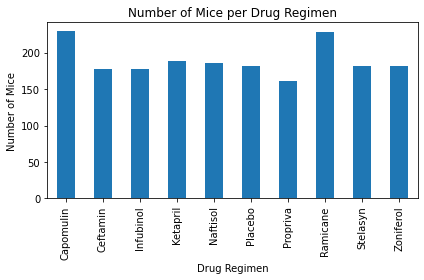

In [115]:
# Use Pandas to generate a bar plot showing the total number of mice in each treatment regimen throughout the course of the study. 
## Note: this plot will be identical to the one that uses Pyplot
num_mice_in_regimen_df = mouse_study_df[[Columns.mouse_id, Columns.drug_regimen]]
num_mice_in_regimen_gb = num_mice_in_regimen_df.groupby(Columns.drug_regimen).count()

regimen_title = "Number of Mice per Drug Regimen"
regimen_ylabel = "Number of Mice"

num_mice_in_regimen_gb.plot(kind="bar", legend=None)
plt.title(regimen_title)
plt.ylabel(regimen_ylabel)
plt.tight_layout()
plt.show()

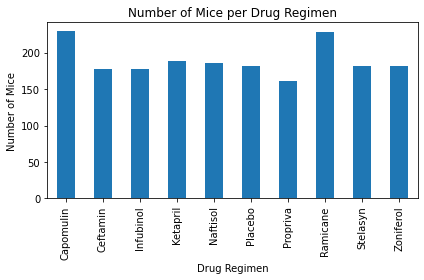

In [119]:
# Use Pyplot to generate a bar plot showing the total number of mice treatment in each treatment regimen throughout the course of the study.
##  Note: this plot will be identical to the one that uses Pandas
num_mice_ids = num_mice_in_regimen_gb[Columns.mouse_id]
x_axis = np.arange(len(num_mice_ids))
tick_locations = [value for value in x_axis]
regimen_labels = num_mice_in_regimen_gb.index

plt.bar(x_axis, num_mice_ids, align="center", width=0.5)
plt.xticks(tick_locations, regimen_labels, rotation=90)
plt.title(regimen_title)
plt.ylabel(regimen_ylabel)
plt.xlabel("Drug Regimen")
plt.xlim(-0.5, len(x_axis)-.5)
plt.tight_layout()
plt.show()

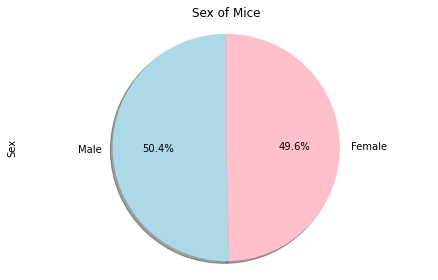

In [67]:
# Use Pandas to generate a pie plot showing the distribution of female versus male mice
## Note: this plot will be identical to the one that uses Pyplot
mice_sex_df = mouse_study_df[[Columns.mouse_id, Columns.sex]]
mice_sex_df = mice_sex_df.drop_duplicates()
mice_sex_vc = mice_sex_df[Columns.sex].value_counts()

sex_colors = ["lightblue", "pink"]
sex_title = "Sex of Mice"
sex_labels = ["Male", "Female"]

mice_sex_vc.plot(kind="pie", \
                 title=sex_title, \
                 labels= sex_labels, \
                 colors=sex_colors, \
                 autopct=pct_fmt, \
                 shadow=True, \
                 startangle=90)
plt.tight_layout()
plt.axis("equal")
plt.show()

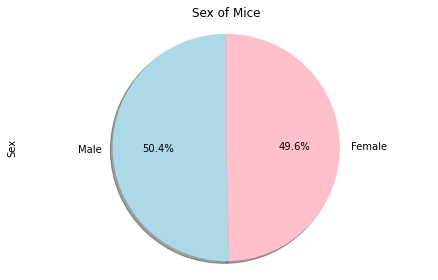

In [120]:
# Use Pyplot to generate a pie plot showing the distribution of female versus male mice
##  Note: this plot will be identical to the one that uses Pandas
plt.pie(mice_sex_vc, \
        labels=sex_labels, \
        colors=sex_colors, \
        shadow=True, \
        autopct=pct_fmt, \
        startangle=90)
plt.title(sex_title)
plt.ylabel("Sex")
plt.tight_layout()
plt.axis("equal")
plt.show()

## Quartiles, Outliers and Boxplots

In [129]:
# Calculate the final tumor volume of each mouse across four of the drug regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (latest) timepoint for each mouse
last_timepoints_gb = mouse_study_df.groupby(Columns.mouse_id)[Columns.timepoint].max()

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
last_tumor_volume_df = pd.merge(mouse_study_df, last_timepoints_gb, on=[Columns.mouse_id, Columns.timepoint])
last_tumor_volume_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,45,22.050126,1
1,s185,Capomulin,Female,3,17,45,23.343598,1
2,x401,Capomulin,Female,16,15,45,28.484033,0
3,m601,Capomulin,Male,22,17,45,28.430964,1
4,g791,Ramicane,Male,11,16,45,29.128472,1


In [164]:
# Put the four drug regimens into a list that can be iterated over in a for-loop 
# (and later used for plot labels)
regimens_under_study = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create empty list to fill with tumor vol data (for plotting)
tumor_data = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for regimen in regimens_under_study:
    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    mice_under_regimen = last_tumor_volume_df.loc[last_tumor_volume_df[Columns.drug_regimen] == regimen]
    tumor_volumes = mice_under_regimen[Columns.tumor_volume]
    
    # add subset 
    tumor_data.append(tumor_volumes)
    
    # Determine outliers using upper and lower bounds
    tumor_quartiles = tumor_volumes.quantile([.25, .75])
    tumor_up_quart = tumor_quartiles[.75]
    tumor_low_quart = tumor_quartiles[.25]
    tumor_iqr = tumor_up_quart - tumor_low_quart
    tumor_offset = (1.5*tumor_iqr)
    tumor_low_bound = tumor_low_quart - tumor_offset
    tumor_up_bound = tumor_up_quart + tumor_offset
    
    tumor_low_outliers = [volume for volume in tumor_volumes if volume <= tumor_low_bound]
    tumor_up_outliers = [volume for volume in tumor_volumes if volume >= tumor_up_bound]
    
    print(f"For {regimen}:")
    print(f"   Volumes under {round(tumor_low_bound, 2)} mm3 may be outliers.")
    for volume in tumor_low_outliers:
        mouse = mice_under_regimen.loc[mice_under_regimen[Columns.tumor_volume] == volume][Columns.mouse_id].item()
        print(f"      Mouse {mouse} - {round(volume,2)} mm3")
    print(f"   Volumes above {round(tumor_up_bound, 2)} mm3 may be outliers.")
    for volume in tumor_up_outliers:
        mouse = mice_under_regimen.loc[mice_under_regimen[Columns.tumor_volume] == volume][Columns.mouse_id].item()
        print(f"      Mouse {mouse} - {round(volume,2)} mm3")
    print("--------------------------------------------")


For Capomulin:
   Volumes under 20.7 mm3 may be outliers.
   Volumes above 51.83 mm3 may be outliers.
--------------------------------------------
For Ramicane:
   Volumes under 17.91 mm3 may be outliers.
   Volumes above 54.31 mm3 may be outliers.
--------------------------------------------
For Infubinol:
   Volumes under 36.83 mm3 may be outliers.
      Mouse c326 - 36.32 mm3
   Volumes above 82.74 mm3 may be outliers.
--------------------------------------------
For Ceftamin:
   Volumes under 25.36 mm3 may be outliers.
   Volumes above 87.67 mm3 may be outliers.
--------------------------------------------


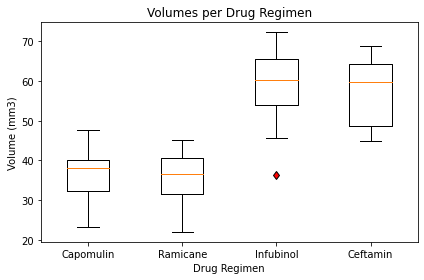

In [156]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
fig, ax = plt.subplots()
outlier_marker = dict(markerfacecolor='r', marker='d') # Use red diamonds for outliers
ax.boxplot(tumor_data, labels=regimens_under_study, flierprops=outlier_marker)
ax.set_title("Volumes per Drug Regimen")
ax.set_ylabel("Volume (mm3)")
ax.set_xlabel("Drug Regimen")
plt.tight_layout()
plt.show()

## Line and Scatter Plots

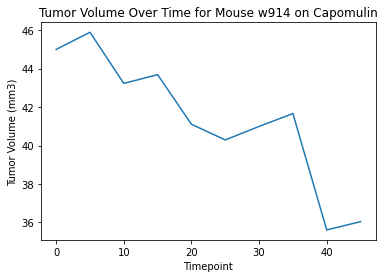

In [198]:
# Generate a line plot of tumor volume vs. timepoint for a mouse treated with Capomulin

# Get random mouse under regimen
regimen = "Capomulin"
mice_under_regimen = mouse_study_df.loc[mouse_study_df[Columns.drug_regimen] == regimen][Columns.mouse_id].unique()
mouse_under_test = random.choice(mice_under_regimen)

# Get Data
mouse_data_under_test = mouse_study_df.loc[mouse_study_df[Columns.mouse_id] == mouse_under_test]
volume_v_timepoint = mouse_data_under_test[[Columns.tumor_volume, Columns.timepoint]]

# Plot Data
volume_v_timepoint.plot(kind="line", x=Columns.timepoint, legend=None)
plt.title(f"Tumor Volume Over Time for Mouse {mouse_under_test} on {regimen}")
plt.ylabel(Columns.tumor_volume)
plt.show()

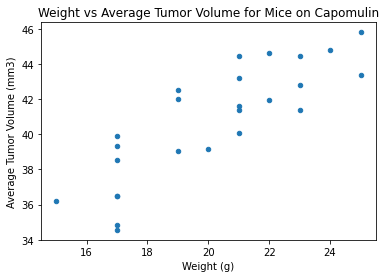

In [214]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen. 
# Note: this means mouse weight goes on the x-axis, with average tumor volume on the y-axis.
regimen = "Capomulin"
regimen_data = mouse_study_df.loc[mouse_study_df[Columns.drug_regimen] == regimen]
tumor_v_weight_gb = regimen_data.groupby(Columns.mouse_id).mean()

tumor_v_weight_gb.plot(kind="scatter", x=Columns.weight, y=Columns.tumor_volume)
plt.title(f"Weight vs Average Tumor Volume for Mice on {regimen}")
plt.ylabel(f"Average {Columns.tumor_volume}")
plt.show()

## Correlation and Regression

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen.
